# Install necessary packages


In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.6 MB/s eta 0:00:00


# Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs
from pmdarima import auto_arima
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_predict
import datetime

In [ ]:
df = pd.read_csv("Google_stock_price.csv")
df.Date = pd.to_datetime(df.Date)
df2 = df.set_index('Date')

In [ ]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1957 entries, 0 to 1956
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1957 non-null   datetime64[ns]
 1   Open    1957 non-null   float64       
 2   High    1957 non-null   float64       
 3   Low     1957 non-null   float64       
 4   Close   1957 non-null   float64       
 5   Volume  1957 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 91.9 KB
None
                                Date         Open         High          Low  \
count                           1957  1957.000000  1957.000000  1957.000000   
mean   2018-02-13 07:21:47.920286208    57.810925    58.356413    57.286576   
min              2014-03-27 16:00:00    24.660000    24.730000    24.310000   
25%              2016-03-07 16:00:00    36.140000    36.410000    35.830000   
50%              2018-02-13 16:00:00    52.130000    52.740000    51.420

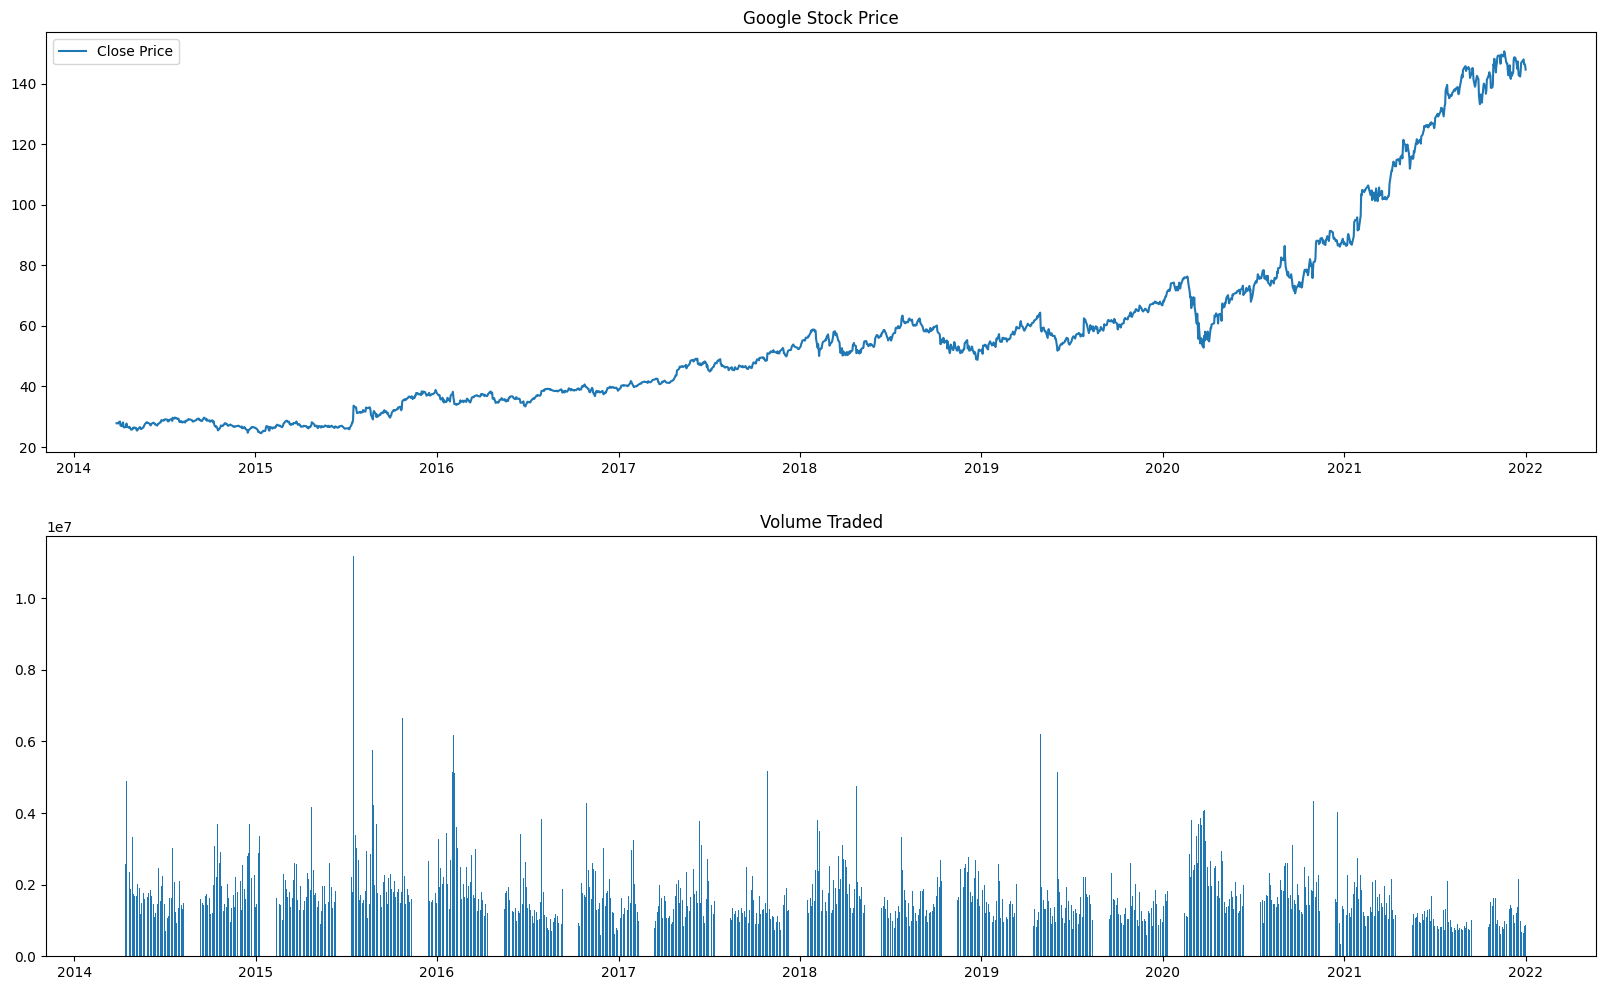

In [ ]:
plt.figure(figsize=(20,12))
plt.subplot(2, 1, 1)
plt.title('Google Stock Price')
plt.plot(df2.Close, label='Close Price')
plt.legend()
plt.subplot(2, 1, 2)
plt.title('Volume Traded')
plt.bar(x=df2.index, height=df2['Volume'])
plt.show()

In [ ]:
data = df["Close"].tolist()
result = adfuller(data)
print("1. ADF:", result[0])
print("2. P-Value:", result[1])
print("3. Num Of Lags:", result[2])
print("4. Num Of Observations Used For ADF Regression:", result[3])
print("5. Critical Values:")
for key, val in result[4].items():
    print(f"\t{key}: {val}")

1. ADF: 2.0149104180663975
2. P-Value: 0.9986920152065939
3. Num Of Lags: 20
4. Num Of Observations Used For ADF Regression: 1936
5. Critical Values:
	1%: -3.433732227090619
	5%: -2.863034058711895
	10%: -2.5675653775463596


In [ ]:
d_value = ndiffs(data, test="adf")
print("d value:", d_value)

d value: 1


In [ ]:
x_train = data[:-100]
x_test = data[-100:]
print(len(x_train), len(x_test))

1857 100


In [ ]:
stepwise_fit = auto_arima(data, trace=True, suppress_warnings=True)
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=5.53 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=7206.577, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=6514.386, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.49 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=6316.192, Time=0.21 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=6186.452, Time=0.25 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=6121.154, Time=0.33 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=6067.089, Time=0.47 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=1.84 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=1.54 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=6069.087, Time=0.86 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 11.737 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1957
Model:         

In [ ]:
model_arima = sm.tsa.arima.ARIMA(data, order=stepwise_fit.order)
model_arima = model_arima.fit()
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1957
Model:                 ARIMA(5, 2, 0)   Log Likelihood               -3027.545
Date:                Sat, 01 Jun 2024   AIC                           6067.089
Time:                        04:31:07   BIC                           6100.558
Sample:                             0   HQIC                          6079.392
                               - 1957                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8750      0.014    -61.311      0.000      -0.903      -0.847
ar.L2         -0.6540      0.020    -33.208      0.000      -0.693      -0.615
ar.L3         -0.5005      0.021    -24.323      0.0

In [ ]:
start = len(x_train)
end = len(x_train) + len(x_test) - 1
pred_arima = model_arima.predict(start=start, end=end)
s_arima = pd.Series(pred_arima, index=df2.index[-100:])

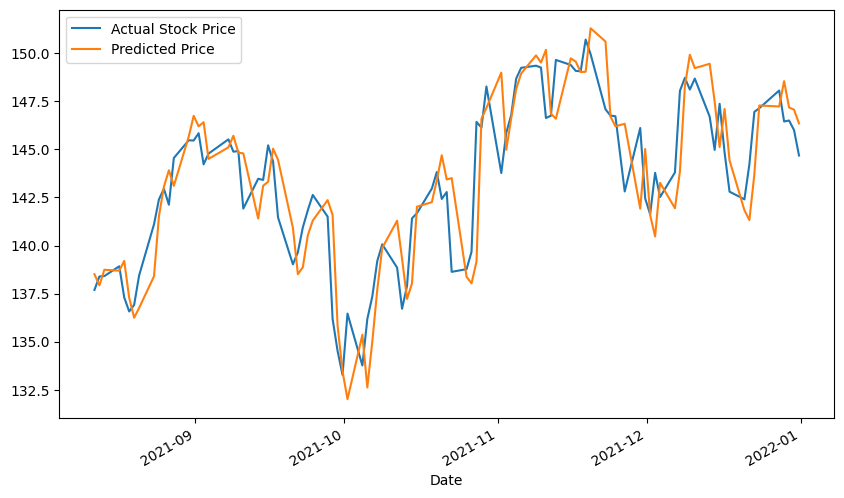

In [ ]:
plt.figure(figsize=(10,6), dpi=100)
df2['Close'][-100:].plot(label='Actual Stock Price', legend=True)
s_arima.plot(label='Predicted Price', legend=True)
plt.show()

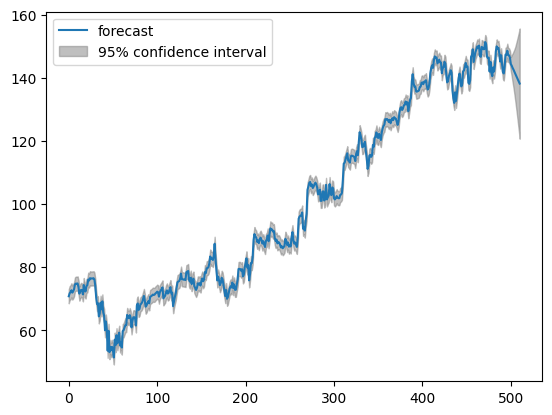

In [ ]:
plot_predict(model_arima, start=len(data)-500, end=len(data)+10, dynamic=False)
plt.show()

In [ ]:
rmse_arima = np.sqrt(mean_squared_error(x_test, pred_arima))
r2_arima = r2_score(x_test, pred_arima)
print("ARIMA RMSE:", rmse_arima)
print("ARIMA R2 Score:", r2_arima)

ARIMA RMSE: 2.1236020406914506
ARIMA R2 Score: 0.7353118791131914


In [ ]:
pred_future_arima = model_arima.predict(start=end+1, end=end+10)
print("ARIMA Future Predictions:", pred_future_arima)

ARIMA Future Predictions: [144.3082854  143.80271431 143.10460194 142.5476834  141.88894582
 141.20748366 140.62709561 140.01044134 139.38023623 138.75955144]


In [ ]:
start_date = datetime.datetime(2021, 12, 31)
dates = [start_date + datetime.timedelta(days=idx) for idx in range(10)]

In [ ]:
pred_future2_arima = pd.Series(pred_future_arima, index=dates)

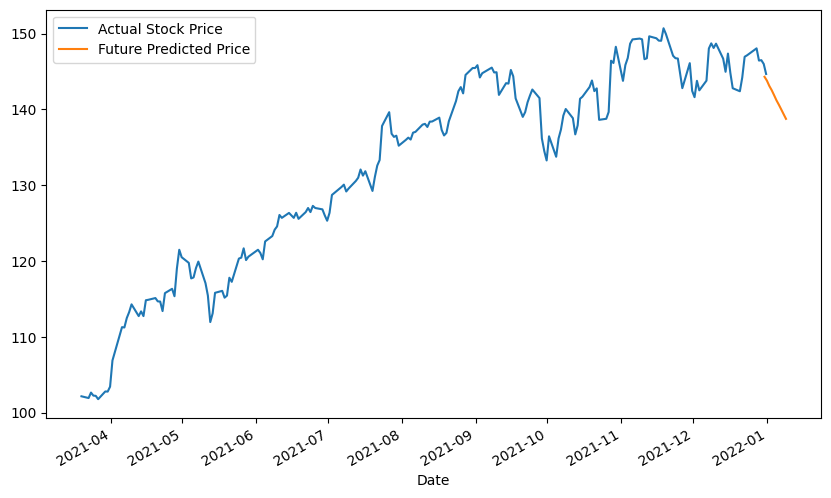

In [ ]:
plt.figure(figsize=(10, 6), dpi=100)
df2['Close'][-200:].plot(label='Actual Stock Price', legend=True)
pred_future2_arima.plot(label='Future Predicted Price', legend=True)
plt.show()

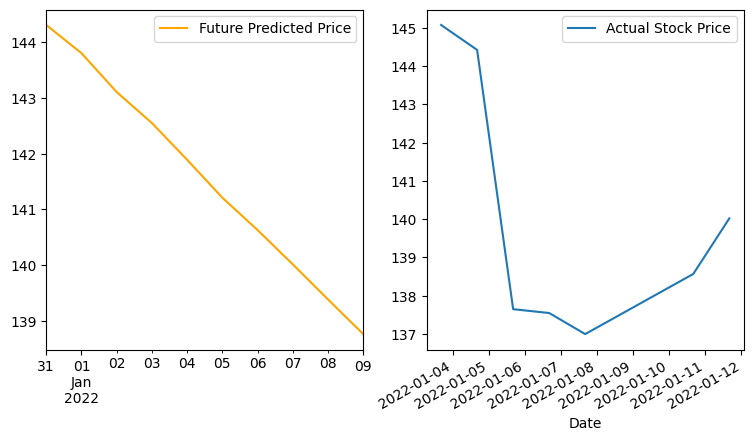

In [ ]:
check_df = pd.read_csv("Google_stock_price-future_values.csv")
check_df.Date = pd.to_datetime(check_df.Date)
check_df2 = check_df.set_index('Date')

plt.figure(figsize=(9, 5), dpi=100)
plt.subplot(1, 2, 1)
pred_future2_arima.plot(label='Future Predicted Price', legend=True, color='orange')
plt.subplot(1, 2, 2)
check_df2['Close'].plot(label='Actual Stock Price', legend=True)
plt.show()

In [ ]:
stepwise_fit_arma = auto_arima(data, start_p=1, start_q=1, max_p=10, max_q=10, seasonal=False, stepwise=True, suppress_warnings=True, trace=True)
model_arma = sm.tsa.arima.ARIMA(data, order=(stepwise_fit_arma.order[0], 0, stepwise_fit_arma.order[1]))
model_arma = model_arma.fit()
print(model_arma.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=4.49 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=7208.577, Time=0.14 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=6516.385, Time=0.30 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.99 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=7206.577, Time=0.07 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=6318.191, Time=0.38 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=6188.450, Time=0.48 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=6123.152, Time=0.61 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=6069.087, Time=0.89 sec
 ARIMA(6,2,0)(0,0,0)[0] intercept   : AIC=5945.666, Time=0.94 sec
 ARIMA(7,2,0)(0,0,0)[0] intercept   : AIC=5934.209, Time=1.23 sec
 ARIMA(8,2,0)(0,0,0)[0] intercept   : AIC=5876.367, Time=1.51 sec
 ARIMA(9,2,0)(0,0,0)[0] intercept   : AIC=5858.560, Time=2.25 sec
 ARIMA(10,2,0)(0,0,0)[0] intercept   : AIC=5852.629, Time=3.30 sec
 ARIMA(10,2,1)(0,0,0)[0] intercept   : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1957
Model:                ARIMA(10, 0, 2)   Log Likelihood               -2821.074
Date:                Sat, 01 Jun 2024   AIC                           5670.147
Time:                        04:32:26   BIC                           5748.256
Sample:                             0   HQIC                          5698.858
                               - 1957                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         57.9058      3e-07   1.93e+08      0.000      57.906      57.906
ar.L1         -0.7827      0.044    -17.819      0.000      -0.869      -0.697
ar.L2          0.8885      0.020     43.843      0.0

In [ ]:
start = len(x_train)
end = len(x_train) + len(x_test) - 1
pred_arma = model_arma.predict(start=start, end=end)

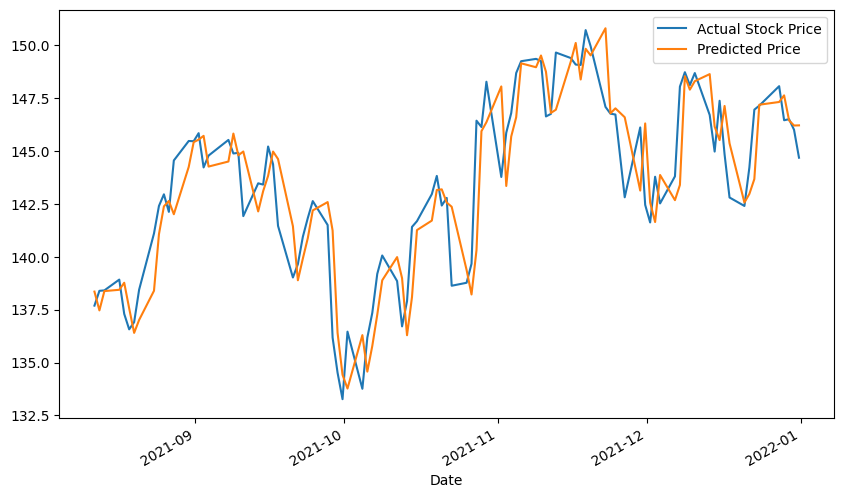

In [ ]:
s_arma = pd.Series(pred_arma, index=df2.index[-100:])
plt.figure(figsize=(10,6), dpi=100)
df2['Close'][-100:].plot(label='Actual Stock Price', legend=True)
s_arma.plot(label='Predicted Price', legend=True)
plt.show()

In [ ]:
rmse_arma = np.sqrt(mean_squared_error(x_test, pred_arma))
r2_arma = r2_score(x_test, pred_arma)
print("ARMA RMSE:", rmse_arma)
print("ARMA R2 Score:", r2_arma)

ARMA RMSE: 1.9004222598951304
ARMA R2 Score: 0.7880231666036054


In [ ]:
pred_future_arma = model_arma.predict(start=end+1, end=end+10)
print("ARMA Future Predictions:", pred_future_arma)

ARMA Future Predictions: [144.82089605 144.81283408 145.04533682 144.83427002 145.08588122
 144.95679164 144.88513661 145.00052127 144.8529931  145.02235454]


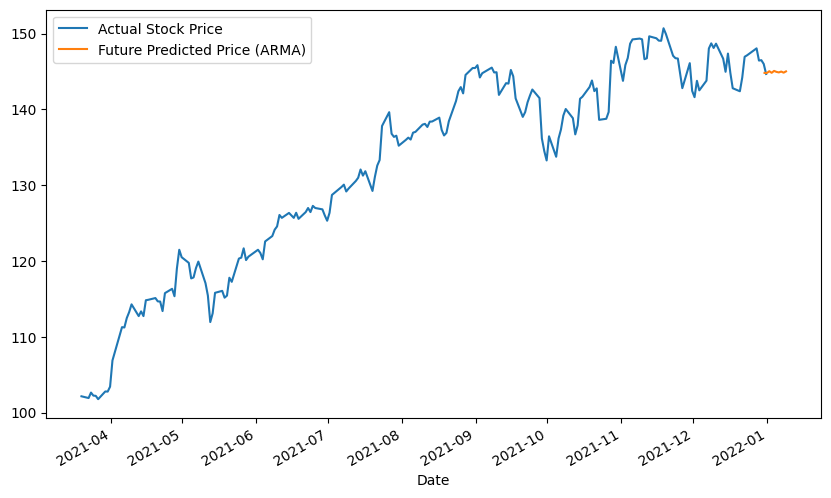

In [ ]:
pred_future2_arma = pd.Series(pred_future_arma, index=dates)

plt.figure(figsize=(10, 6), dpi=100)
df2['Close'][-200:].plot(label='Actual Stock Price', legend=True)
pred_future2_arma.plot(label='Future Predicted Price (ARMA)', legend=True)
plt.show()

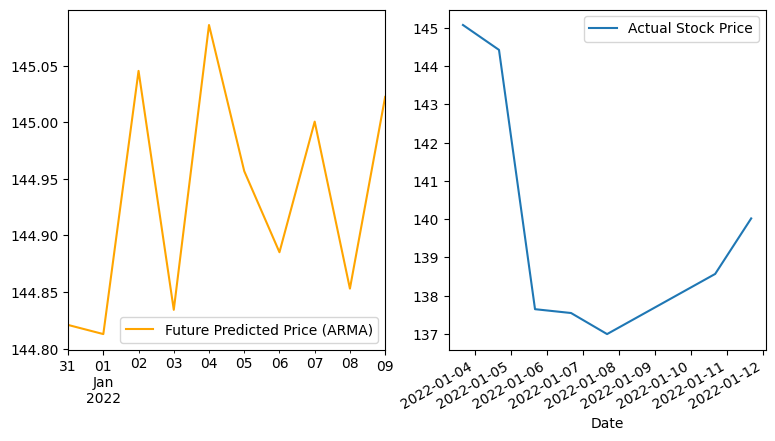

In [ ]:
plt.figure(figsize=(9, 5), dpi=100)
plt.subplot(1, 2, 1)
pred_future2_arma.plot(label='Future Predicted Price (ARMA)', legend=True, color='orange')
plt.subplot(1, 2, 2)
check_df2['Close'].plot(label='Actual Stock Price', legend=True)
plt.show()